In [39]:
"""
Detecção e Classificação Automática de Rótulos Frontais de Produtos Alimentícios com Ênfase nos Selos da ANVISA
Disciplina: Inteligência Artificial 7ºN CC
Professor: Ivan Carlos Alcantara de Oliveira
Instituição: Universidade Presbiteriana Mackenzie
Semestre: 2025.2

Integrantes:
- Bruno Roveri Custodio   RA: 10401752
- Vinicius Serpa Pansan   RA: 10254346

Síntese do conteúdo:
Este arquivo contém a etapa de exploração e preparação dos dados para o treinamento do modelo de detecção.
Inclui inspeção do dataset, verificação de integridade, análise de distribuição das classes e combinações,
estatísticas das imagens e visualização de amostras anotadas.

Dados e origem:
Todas as imagens utilizadas no dataset foram produzidas e fotografadas pelo próprio grupo, sendo de autoria própria. As fotos foram organizadas
manualmente em pastas de treino, validação e testes.
para identificar os selos nutricionais frontais, alto em açúcar, gordura saturada e sódio.

Dependências principais:
- Python 3.10
- NumPy 1.26
- Pandas 2.2
- Matplotlib 3.7
- Pillow 10
- OpenCV 4.8
- PyYAML 6
- roboflow 1.1
- ultralytics 8.x  (YOLOv8)

Como executar:
Rodar célula por célula no Jupyter Notebook (Colab ou local) na ordem apresentada,
após garantir a instalação das dependências e a configuração correta dos caminhos
para o dataset. O bloco de conversão de labels deve ser executado antes da análise.

Histórico de alterações:
- Bruno Roveri Custodio -> Estruturação inicial do notebook, organização do dataset e parte da análise exploratória
- Vinicius Serpa Pansan -> Desenvolvimento das rotinas de análise exploratória, geração dos gráficos e validação do dataset
"""

'\nDetecção e Classificação Automática de Rótulos Frontais de Produtos Alimentícios com Ênfase nos Selos da ANVISA\nDisciplina: Inteligência Artificial 7ºN CC\nProfessor: Ivan Carlos Alcantara de Oliveira\nInstituição: Universidade Presbiteriana Mackenzie\nSemestre: 2025.2\n\nIntegrantes:\n- Bruno Roveri Custodio   RA: 10401752\n- Vinicius Serpa Pansan   RA: 10254346\n\nSíntese do conteúdo:\nEste arquivo contém a etapa de exploração e preparação dos dados para o treinamento do modelo de detecção.\nInclui inspeção do dataset, verificação de integridade, análise de distribuição das classes e combinações,\nestatísticas das imagens e visualização de amostras anotadas.\n\nDados e origem:\nTodas as imagens utilizadas no dataset foram produzidas e fotografadas pelo próprio grupo, sendo de autoria própria. As fotos foram organizadas\nmanualmente em pastas de treino, validação e testes.\npara identificar os selos nutricionais frontais, alto em açúcar, gordura saturada e sódio.\n\nDependências p

In [40]:
# Instalação da biblioteca Ultralytics para YOLOv8
!pip install ultralytics
!pip install opencv-python matplotlib pandas

In [41]:
!git clone https://github.com/OFFSerpa/IA_IdentificacaoRotulagem.git

fatal: destination path 'IA_IdentificacaoRotulagem' already exists and is not an empty directory.


In [42]:
import os

caminho_dataset = './IA_IdentificacaoRotulagem/DataSet'
arquivos = os.listdir(caminho_dataset)

arquivos_imagens = [f for f in os.listdir(caminho_dataset) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

print(f"Número de imagens no dataset: {len(arquivos)}")

Número de imagens no dataset: 50


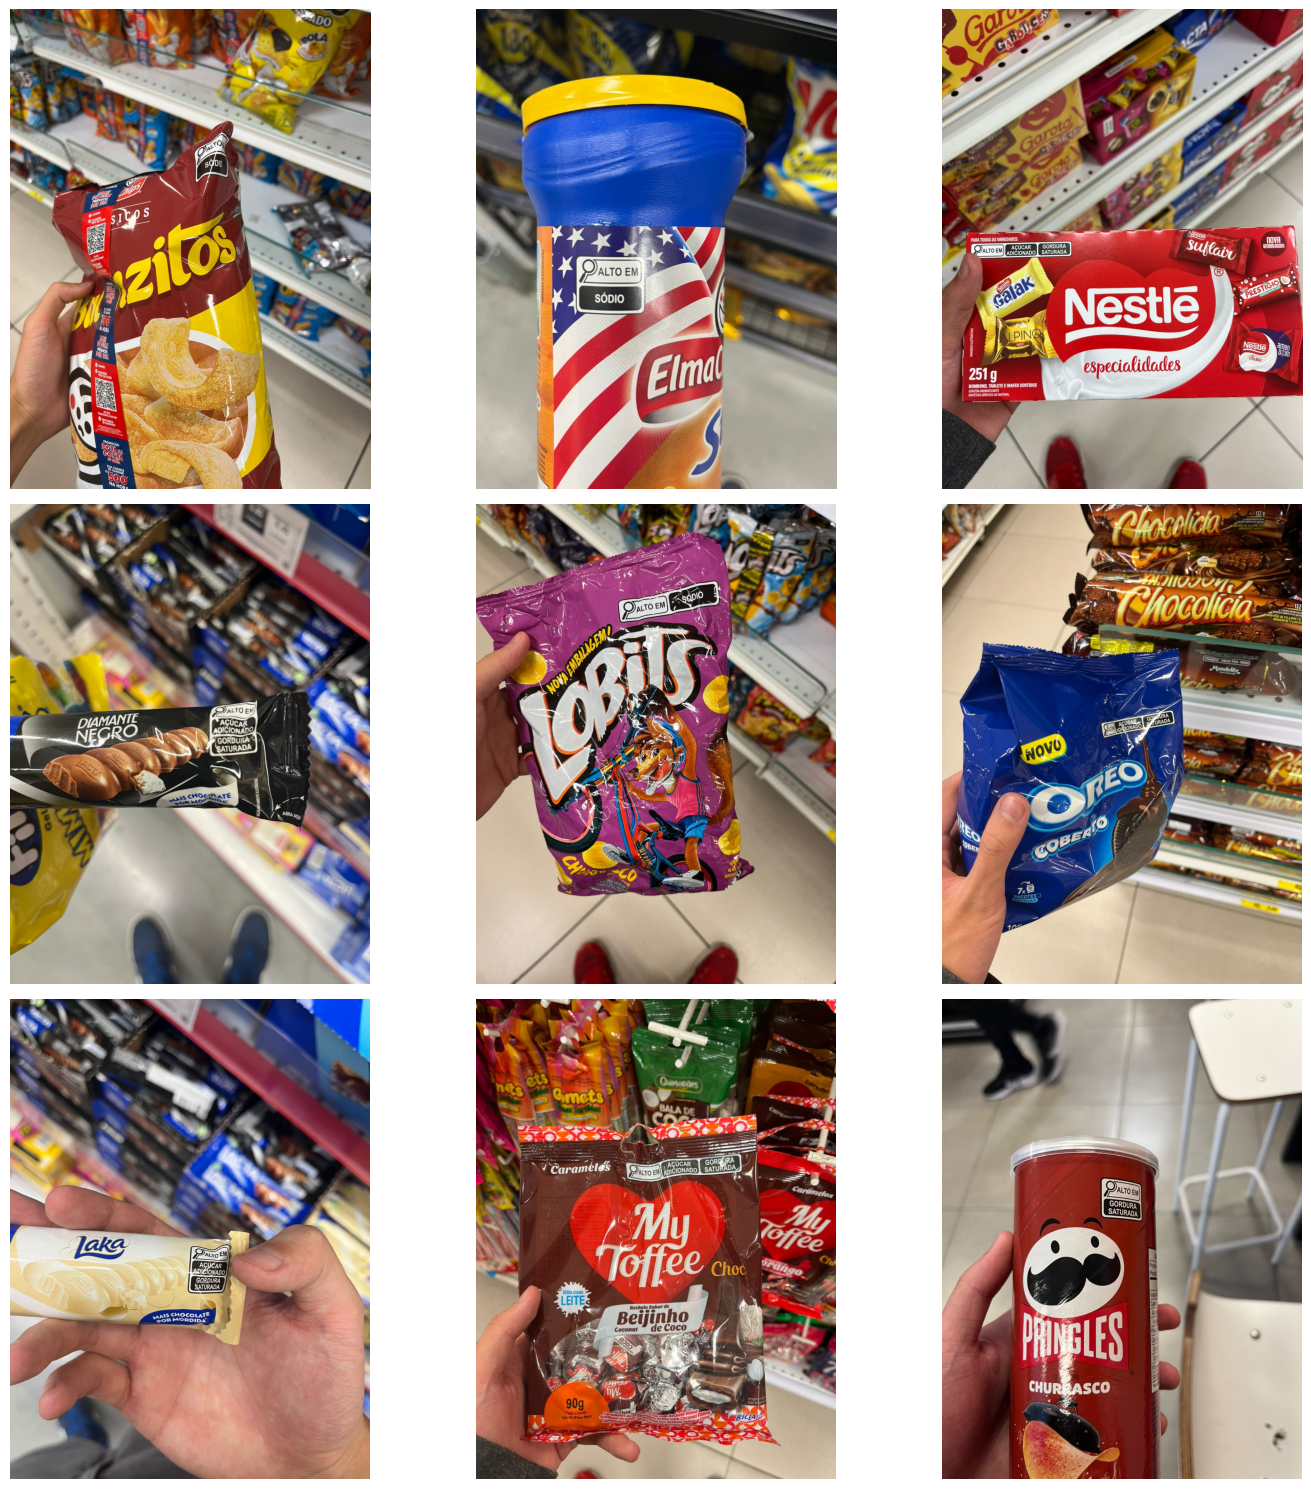

In [43]:
import matplotlib.pyplot as plt
from PIL import Image
import math

arquivos_para_visualizar = arquivos_imagens[:9]

cols = 3
rows = math.ceil(len(arquivos_para_visualizar) / cols)

plt.figure(figsize=(15, 5 * rows))

for i, nome_arquivo in enumerate(arquivos_para_visualizar):
    caminho_completo_imagem = os.path.join(caminho_dataset, nome_arquivo)
    try:
        imagem = Image.open(caminho_completo_imagem)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(imagem)
        plt.axis('off')
    except Exception as e:
        print(f"Não foi possível abrir {nome_arquivo}: {e}")

plt.tight_layout()
plt.show()

In [44]:
!pip install -q roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="6NaM67ILxCQiHgyyK6AS")
project = rf.workspace("projetoia-truvr").project("projeto-ia-0pwpo")
version = project.version(1)
dataset = version.download("yolov8")

base = dataset.location
print("Base YOLO:", base)

loading Roboflow workspace...
loading Roboflow project...
Base YOLO: /content/Projeto-IA-1


Usando labels de treino em: /content/Projeto-IA-1/train/labels_fixed


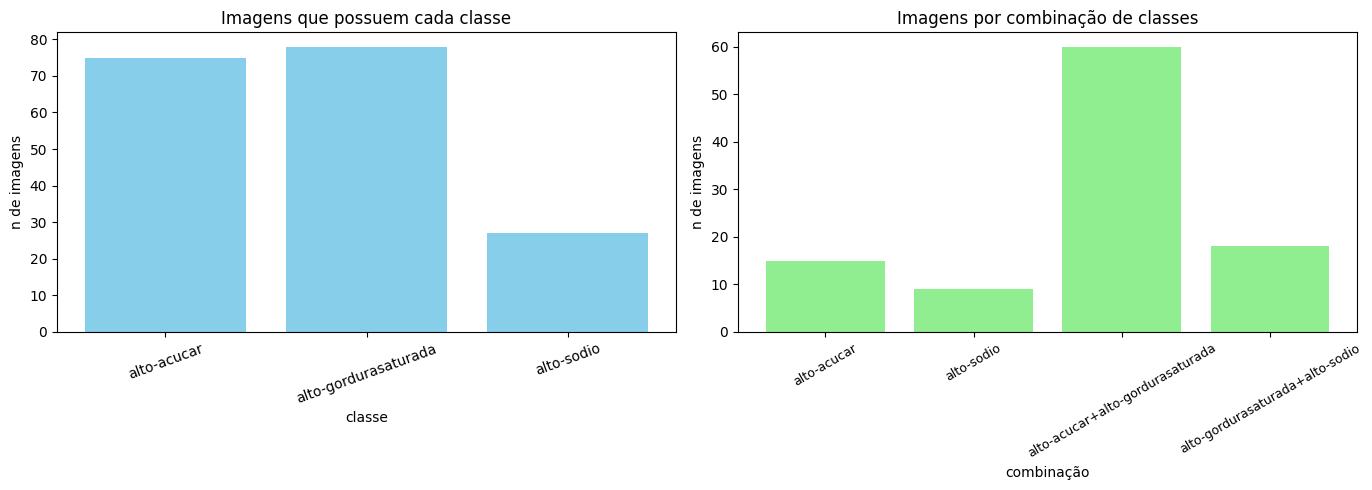

nome  imagens
0                       alto-acucar       15
1                        alto-sodio        9
2  alto-acucar+alto-gordurasaturada       60
3   alto-gordurasaturada+alto-sodio       18

In [45]:
import os, glob
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

caminho_labels_treino = os.path.join(base, "train", "labels_fixed")
if not os.path.exists(caminho_labels_treino):
    caminho_labels_treino = os.path.join(base, "train", "labels")
print(f"Usando labels de treino em: {caminho_labels_treino}")

nomes_classes = ['alto-acucar', 'alto-gordurasaturada', 'alto-sodio']

labels_por_imagem = defaultdict(set)
for arquivo_label in glob.glob(os.path.join(caminho_labels_treino, '*.txt')):
    img_id = os.path.splitext(os.path.basename(arquivo_label))[0]
    with open(arquivo_label, 'r') as f:
        for linha in f:
            partes = linha.strip().split()
            if len(partes) == 5 and partes[0].isdigit():
                id_classe = int(partes[0])
                if 0 <= id_classe < len(nomes_classes):
                    labels_por_imagem[img_id].add(nomes_classes[id_classe])

# contagem por classe por imagem
contagem_por_classe_img = {cls: 0 for cls in nomes_classes}
for classes_set in labels_por_imagem.values():
    for cls in classes_set:
        contagem_por_classe_img[cls] += 1

# contagem de combinações por imagem
comb_counter = Counter(frozenset(s) for s in labels_por_imagem.values())
comb_list = sorted(comb_counter.items(), key=lambda kv: (len(kv[0]), tuple(sorted(list(kv[0])))))

df_classes_img = pd.DataFrame.from_dict(contagem_por_classe_img, orient="index", columns=["imagens"])
df_combinacoes = pd.DataFrame(
    {"nome": ["+".join(sorted(list(c))) if c else "(sem classe)" for c, _ in comb_list],
     "imagens": [q for _, q in comb_list]}
)

fig, axes = plt.subplots(1, 2, figsize=(14,5))
axes[0].bar(df_classes_img.index, df_classes_img["imagens"], color="skyblue")
axes[0].set_title("Imagens que possuem cada classe")
axes[0].set_xlabel("classe")
axes[0].set_ylabel("n de imagens")
axes[0].tick_params(axis="x", rotation=20)

axes[1].bar(df_combinacoes["nome"], df_combinacoes["imagens"], color="lightgreen")
axes[1].set_title("Imagens por combinação de classes")
axes[1].set_xlabel("combinação")
axes[1].set_ylabel("n de imagens")
axes[1].tick_params(axis="x", rotation=30, labelsize=9)

plt.tight_layout()
plt.show()

df_combinacoes

In [46]:
import os, glob

def checar_integridade_split(base_dir, split):
    img_dir = os.path.join(base_dir, split, "images")
    lab_dir = os.path.join(base_dir, split, "labels")

    if not os.path.exists(img_dir) or not os.path.exists(lab_dir):
        print(f"{split}: pastas de images ou labels não encontradas")
        return [], []

    imgs = {os.path.splitext(os.path.basename(p))[0] for p in glob.glob(os.path.join(img_dir, "*"))}
    labs = {os.path.splitext(os.path.basename(p))[0] for p in glob.glob(os.path.join(lab_dir, "*.txt"))}

    sem_label = sorted(list(imgs - labs))
    sem_imagem = sorted(list(labs - imgs))
    print(f"{split}: imagens sem label = {len(sem_label)} | labels sem imagem = {len(sem_imagem)}")

    if sem_label:
        print(f"{split}: exemplos de imagens sem label:", sem_label[:5])
    if sem_imagem:
        print(f"{split}: exemplos de labels sem imagem:", sem_imagem[:5])

    return sem_label, sem_imagem

for sp in ["train", "valid", "test"]:
    if os.path.exists(os.path.join(caminho_dataset, sp)):
        checar_integridade_split(caminho_dataset, sp)

In [47]:
import pandas as pd
import os, glob

def carregar_labels_df(label_dir):
    rows = []
    for f in glob.glob(os.path.join(label_dir, "*.txt")):
        img_id = os.path.splitext(os.path.basename(f))[0]
        with open(f, "r") as fh:
            for line in fh:
                parts = line.strip().split()
                if len(parts) == 5:
                    cls, xc, yc, w, h = parts
                    w = float(w); h = float(h)
                    rows.append({
                        "img": img_id,
                        "cls": int(cls),
                        "xc": float(xc),
                        "yc": float(yc),
                        "w": w,
                        "h": h,
                        "area": w * h,
                        "aspect": (w / h) if h > 0 else None
                    })
    return pd.DataFrame(rows)

df_train_boxes = carregar_labels_df(caminho_labels_treino)

print("Resumo numérico dos boxes no train")
print(df_train_boxes[["xc","yc","w","h","area","aspect"]].describe())

print("\nBoxes por imagem no train")
print(df_train_boxes.groupby("img").size().describe())

Resumo numérico dos boxes no train
               xc          yc           w           h        area      aspect
count  180.000000  180.000000  180.000000  180.000000  180.000000  180.000000
mean     0.508941    0.424401    0.239761    0.123950    0.028975    2.415433
std      0.126428    0.155976    0.097911    0.046875    0.015139    1.864184
min      0.167187    0.064062    0.091406    0.035937    0.005585    0.852941
25%      0.428906    0.343164    0.160156    0.095312    0.017164    1.150794
50%      0.525000    0.454688    0.204687    0.118750    0.023254    1.485294
75%      0.582031    0.521094    0.334961    0.159766    0.039566    3.285714
max      0.824219    0.672656    0.417187    0.234375    0.070723    9.000000

Boxes por imagem no train
count    102.000000
mean       1.764706
std        0.426277
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        2.000000
dtype: float64


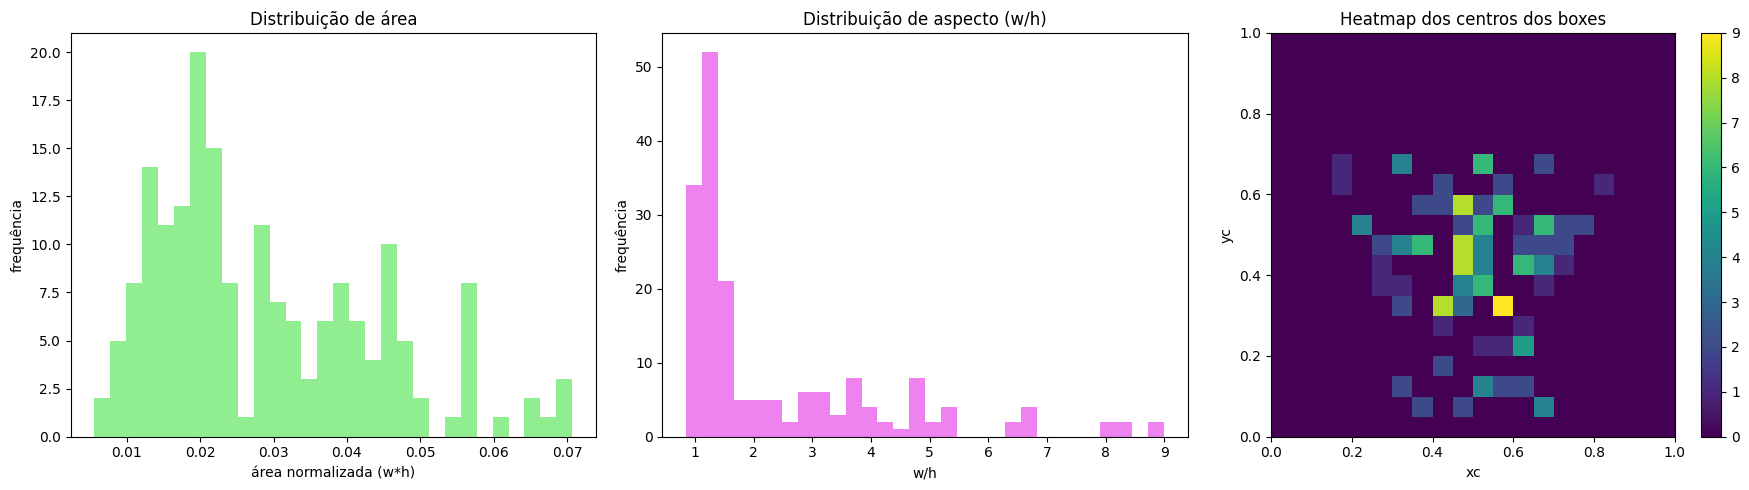

In [48]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18,5))

# Histograma de área
axes[0].hist(df_train_boxes["area"], bins=30, color="lightgreen")
axes[0].set_title("Distribuição de área")
axes[0].set_xlabel("área normalizada (w*h)")
axes[0].set_ylabel("frequência")

# Histograma de aspecto
axes[1].hist(df_train_boxes["aspect"].dropna(), bins=30, color="violet")
axes[1].set_title("Distribuição de aspecto (w/h)")
axes[1].set_xlabel("w/h")
axes[1].set_ylabel("frequência")

# Heatmap dos centros
bins = 20
H, xedges, yedges = np.histogram2d(
    df_train_boxes["xc"], df_train_boxes["yc"],
    bins=bins, range=[[0,1],[0,1]]
)
im = axes[2].imshow(H.T, origin="lower", extent=[0,1,0,1], aspect="equal")
axes[2].set_title("Heatmap dos centros dos boxes")
axes[2].set_xlabel("xc")
axes[2].set_ylabel("yc")
fig.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()

In [49]:
import os, glob
import pandas as pd

NOMES_FIX = ['alto-acucar', 'alto-gordurasaturada', 'alto-sodio']

def carregar_labels_df(label_dir):
    rows = []
    for f in glob.glob(os.path.join(label_dir, "*.txt")):
        with open(f) as fh:
            for line in fh:
                parts = line.strip().split()
                if len(parts) == 5 and parts[0].isdigit():
                    rows.append(int(parts[0]))
    return pd.DataFrame(rows, columns=["cls"])

def cobertura_classes_split(base_dir, split, nomes_classes):
    lab_dir = os.path.join(base_dir, split, "labels_fixed")
    if not os.path.exists(lab_dir):
        return pd.Series(dtype=int)
    df = carregar_labels_df(lab_dir)
    if df.empty:
        return pd.Series(dtype=int)
    cont = df["cls"].value_counts().sort_index()
    cont = cont.reindex(range(len(nomes_classes)), fill_value=0)
    cont.index = nomes_classes
    return cont

# Monta contagem + percentual por classe em cada split
splits = [s for s in ["train", "valid", "test"] if os.path.exists(os.path.join(base, s))]
tabelas = []
for sp in splits:
    cont = cobertura_classes_split(base, sp, NOMES_FIX)
    total = cont.sum()
    df_tmp = pd.DataFrame({
        "classe": cont.index,
        f"{sp}_contagem": cont.values,
        f"{sp}_percentual": (100*cont/total).round(2) if total > 0 else 0
    })
    tabelas.append(df_tmp)

# Junta todos os splits
df_cobertura = tabelas[0]
for df_tmp in tabelas[1:]:
    df_cobertura = df_cobertura.merge(df_tmp, on="classe", how="outer")

df_cobertura = df_cobertura.fillna(0).set_index("classe").astype(int)
display(df_cobertura)

train_contagem  train_percentual
classe                                                
alto-acucar                       75                41
alto-gordurasaturada              78                43
alto-sodio                        27                15

In [50]:
import os, glob, yaml

# Detecta a raiz do dataset
for cand in ['/content/Projeto-IA-1', './IA_IdentificacaoRotulagem/DataSet']:
    if any(os.path.exists(os.path.join(cand, sp, 'labels')) for sp in ['train','valid','test']):
        base = cand
        break
else:
    raise RuntimeError("Nenhuma raiz com pastas de labels encontrada.")

print(f"Usando base: {base}")

# Mapeamento para 3 classes alvo
classes_alvo = ['alto-acucar', 'alto-gordurasaturada', 'alto-sodio']
mapa_oldid_para_newids = {0:[0], 1:[0,1], 2:[1,2], 3:[2]}

def converter_labels_split(split):
    lab_dir = os.path.join(base, split, "labels")
    if not os.path.exists(lab_dir):
        print(f"{split}: sem pasta de labels, pulando"); return 0
    lab_fix = os.path.join(base, split, "labels_fixed")
    os.makedirs(lab_fix, exist_ok=True)
    convertidos = 0
    for f in glob.glob(os.path.join(lab_dir, "*.txt")):
        out = []
        with open(f) as fh:
            for line in fh:
                p = line.strip().split()
                if len(p) != 5 or not p[0].isdigit():
                    continue
                old_id = int(p[0])
                if old_id in mapa_oldid_para_newids:
                    for new_id in mapa_oldid_para_newids[old_id]:
                        out.append(f"{new_id} {p[1]} {p[2]} {p[3]} {p[4]}\n")
        with open(os.path.join(lab_fix, os.path.basename(f)), "w") as g:
            g.writelines(out)
        convertidos += 1
    print(f"{split}: {convertidos} arquivos convertidos em {lab_fix}")
    return convertidos

total = 0
for sp in ["train", "valid", "test"]:
    total += converter_labels_split(sp)
print(f"Total convertidos: {total}")

# Cria data_fixed.yaml com 3 classes
cfg = {"names": classes_alvo, "nc": len(classes_alvo)}
yaml_out = os.path.join(base, "data_fixed.yaml")
with open(yaml_out, "w") as f:
    yaml.safe_dump(cfg, f, sort_keys=False, allow_unicode=True)
print(f"data_fixed.yaml salvo em {yaml_out} com classes {classes_alvo}")

Usando base: /content/Projeto-IA-1
train: 102 arquivos convertidos em /content/Projeto-IA-1/train/labels_fixed
valid: sem pasta de labels, pulando
test: sem pasta de labels, pulando
Total convertidos: 102
data_fixed.yaml salvo em /content/Projeto-IA-1/data_fixed.yaml com classes ['alto-acucar', 'alto-gordurasaturada', 'alto-sodio']


In [51]:
import os, glob
import pandas as pd
from collections import defaultdict

splits = [sp for sp in ["train","valid","test"] if os.path.exists(os.path.join(base, sp, "labels_fixed"))]

def cobertura_por_imagem(lab_dir_fixed, nomes):
    labels_por_imagem = defaultdict(set)
    for f in glob.glob(os.path.join(lab_dir_fixed, "*.txt")):
        img_id = os.path.splitext(os.path.basename(f))[0]
        with open(f) as fh:
            for line in fh:
                p = line.strip().split()
                if len(p) == 5 and p[0].isdigit():
                    cid = int(p[0])
                    if 0 <= cid < len(nomes):
                        labels_por_imagem[img_id].add(nomes[cid])
    cont = {cls: 0 for cls in nomes}
    for s in labels_por_imagem.values():
        for cls in s:
            cont[cls] += 1
    return cont, len(labels_por_imagem)

nomes_fix = ['alto-acucar', 'alto-gordurasaturada', 'alto-sodio']
tabelas = []
for sp in splits:
    lab_dir_fixed = os.path.join(base, sp, "labels_fixed")
    cont, n_imgs = cobertura_por_imagem(lab_dir_fixed, nomes_fix)
    s = pd.Series(cont, name=sp)
    s["total_imagens"] = n_imgs
    tabelas.append(s)

df_cobertura_fix = pd.DataFrame(tabelas).T.fillna(0).astype(int)
print("Cobertura por classe e total de imagens usando labels_fixed")
display(df_cobertura_fix)

for sp in splits:
    ausentes = [c for c in nomes_fix if df_cobertura_fix.at[c, sp] == 0]
    if ausentes:
        print(f"Atenção no {sp}: classes ausentes -> {ausentes}")
    else:
        print(f"{sp}: todas as classes presentes")

Cobertura por classe e total de imagens usando labels_fixed


train
alto-acucar              75
alto-gordurasaturada     78
alto-sodio               27
total_imagens           102

train: todas as classes presentes


In [52]:
import os, glob, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict, Counter

NOMES_FIX = ['alto-acucar', 'alto-gordurasaturada', 'alto-sodio']

def df_labels_from_dir(label_dir, nomes=NOMES_FIX):
    rows = []
    for f in glob.glob(os.path.join(label_dir, "*.txt")):
        img_id = os.path.splitext(os.path.basename(f))[0]
        with open(f) as fh:
            for line in fh:
                p = line.strip().split()
                if len(p) == 5 and p[0].isdigit():
                    cid = int(p[0])
                    xc, yc, w, h = map(float, p[1:])
                    if 0 <= cid < len(nomes):
                        rows.append({
                            "img": img_id, "cls": cid, "xc": xc, "yc": yc,
                            "w": w, "h": h, "area": w*h, "aspect": (w/h) if h > 0 else np.nan
                        })
    return pd.DataFrame(rows)

def integrity_report(split_root):
    img_dir = os.path.join(split_root, "images")
    lab_dir = os.path.join(split_root, "labels_fixed")
    imgs = {os.path.splitext(os.path.basename(p))[0] for p in glob.glob(os.path.join(img_dir, "*"))}
    labs = {os.path.splitext(os.path.basename(p))[0] for p in glob.glob(os.path.join(lab_dir, "*.txt"))}
    return sorted(imgs - labs), sorted(labs - imgs)

def image_shapes(split_root):
    img_dir = os.path.join(split_root, "images")
    shapes = []
    for p in glob.glob(os.path.join(img_dir, "*")):
        try:
            with Image.open(p) as im:
                w, h = im.size
                shapes.append((os.path.splitext(os.path.basename(p))[0], w, h, w/h))
        except Exception:
            pass  # Ignora arquivos corrompidos
    return pd.DataFrame(shapes, columns=["img", "w", "h", "ratio"])


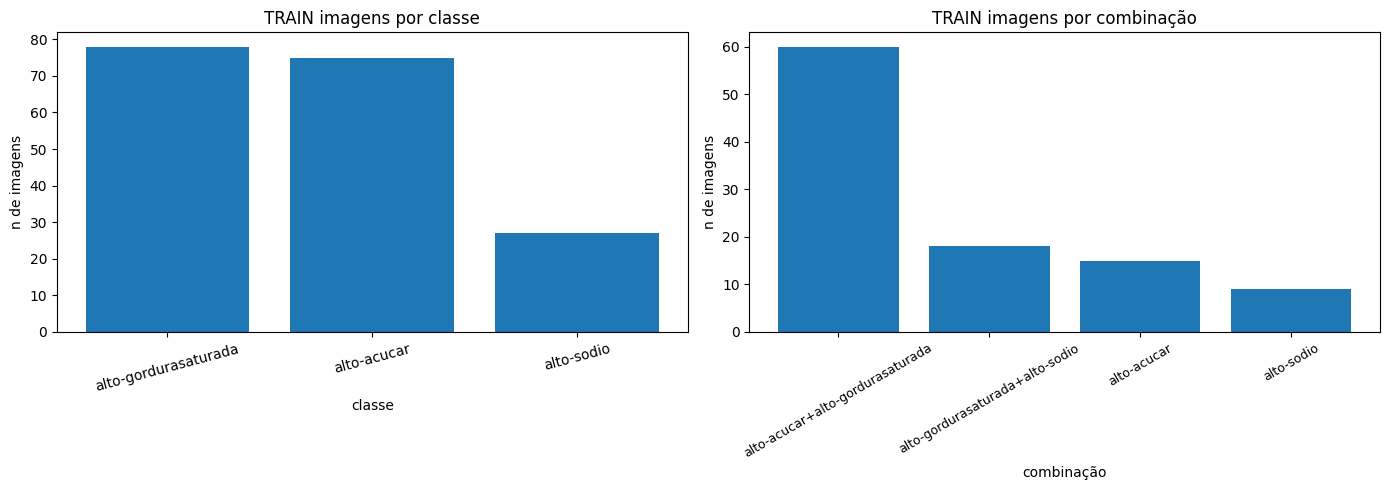

Consolidado imagens por classe por split


train
classe                     
alto-gordurasaturada     78
alto-acucar              75
alto-sodio               27

In [53]:
def cobertura_por_imagem(df, nomes=NOMES_FIX):
    labels_por_imagem = defaultdict(set)
    for r in df.itertuples(index=False):
        labels_por_imagem[r.img].add(nomes[r.cls])
    cont_classe = {c: 0 for c in nomes}
    for s in labels_por_imagem.values():
        for c in s:
            cont_classe[c] += 1
    comb_counter = Counter(frozenset(s) for s in labels_por_imagem.values())
    df_classes = pd.DataFrame.from_dict(cont_classe, orient="index", columns=["imagens"]).sort_values("imagens", ascending=False)
    df_combos = pd.DataFrame({"combinacao": ["+".join(sorted(list(c))) if c else "(sem classe)" for c, _ in comb_counter.items()],
                              "imagens": [q for _, q in comb_counter.items()]})
    df_combos = df_combos.sort_values(["imagens","combinacao"], ascending=[False, True]).reset_index(drop=True)
    return df_classes, df_combos

def plot_classes_e_combos(df_classes, df_combos, titulo_esq, titulo_dir):
    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    axes[0].bar(df_classes.index, df_classes["imagens"])
    axes[0].set_title(titulo_esq)
    axes[0].set_xlabel("classe")
    axes[0].set_ylabel("n de imagens")
    axes[0].tick_params(axis="x", rotation=15)
    axes[1].bar(df_combos["combinacao"], df_combos["imagens"])
    axes[1].set_title(titulo_dir)
    axes[1].set_xlabel("combinação")
    axes[1].set_ylabel("n de imagens")
    axes[1].tick_params(axis="x", rotation=30, labelsize=9)
    plt.tight_layout()
    plt.show()

consol = []
for sp in ["train","valid","test"]:
    split_root = os.path.join(base, sp)
    lab_fix = os.path.join(split_root, "labels_fixed")
    if not os.path.exists(lab_fix):
        continue
    df_lab = df_labels_from_dir(lab_fix)
    if df_lab.empty:
        print(f"{sp}: sem labels_fixed")
        continue
    df_classes, df_combos = cobertura_por_imagem(df_lab)
    plot_classes_e_combos(df_classes, df_combos,
                          f"{sp.upper()} imagens por classe",
                          f"{sp.upper()} imagens por combinação")
    s = df_classes["imagens"].rename(sp)
    s.index.name = "classe"
    consol.append(s)

if consol:
    df_consol = pd.concat(consol, axis=1).fillna(0).astype(int)
    print("Consolidado imagens por classe por split")
    display(df_consol)

Amostras com boxes  train


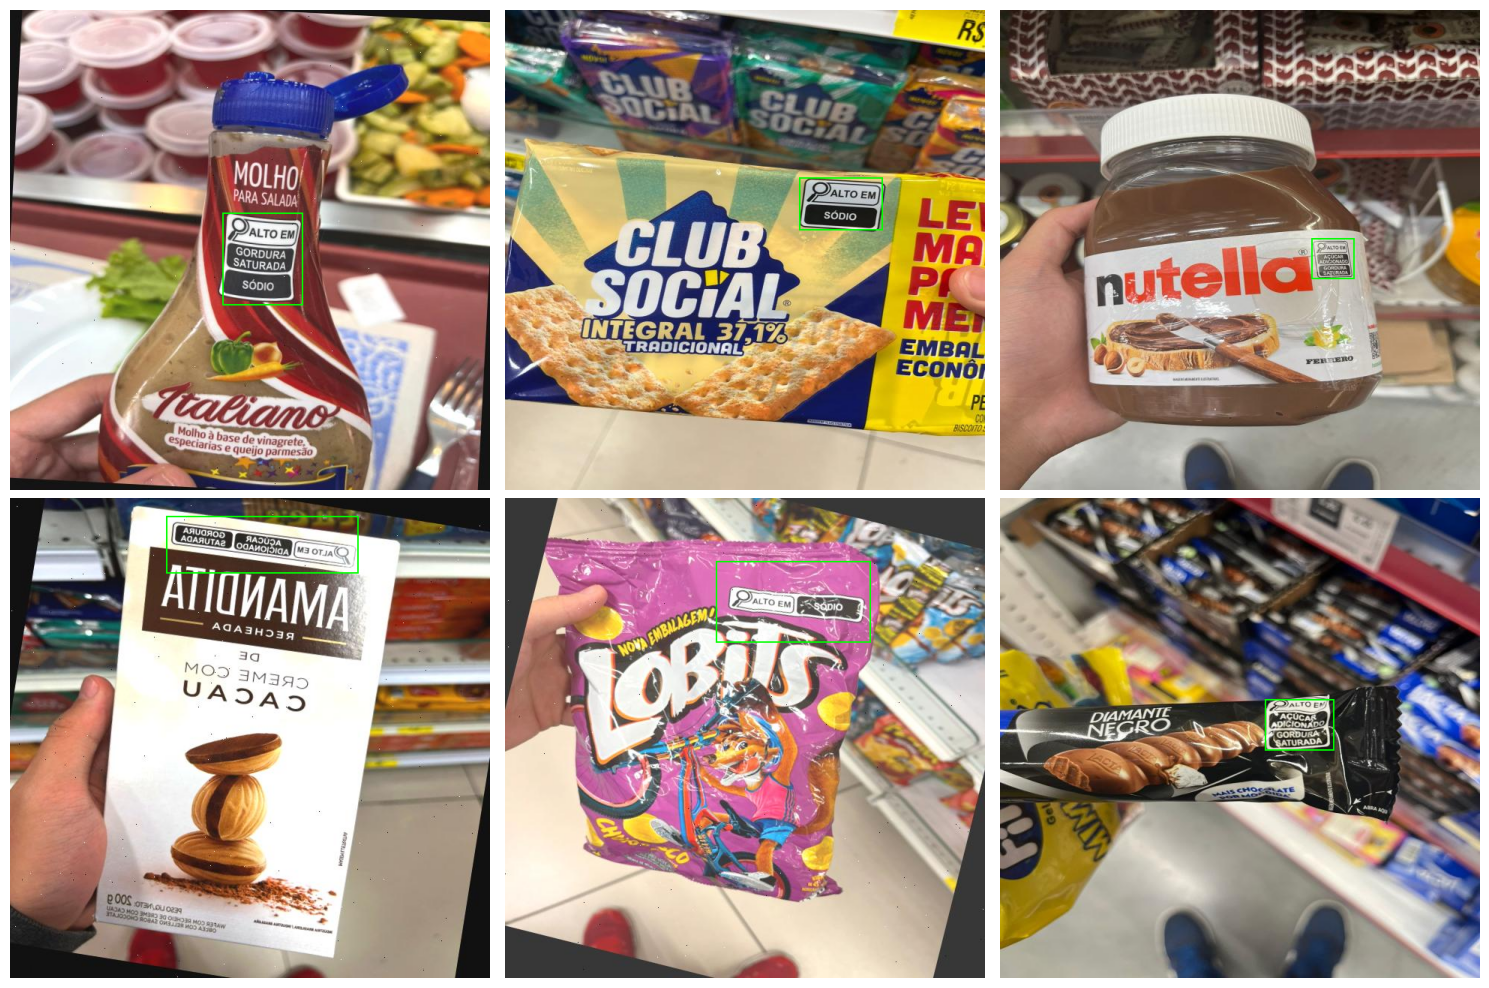

In [54]:
def show_samples_with_boxes(split_root, n=6):
    img_dir = os.path.join(split_root, "images")
    lab_dir = os.path.join(split_root, "labels_fixed")
    paths = glob.glob(os.path.join(img_dir, "*"))
    if not paths:
        print("Sem imagens para visualizar")
        return
    sample = random.sample(paths, min(n, len(paths)))
    cols = 3
    rows = math.ceil(len(sample)/cols)
    plt.figure(figsize=(15, 5*rows))
    for i, p in enumerate(sample):
        stem = os.path.splitext(os.path.basename(p))[0]
        lab = os.path.join(lab_dir, stem + ".txt")
        try:
            img = np.array(Image.open(p).convert("RGB"))
        except Exception:
            continue
        H, W = img.shape[:2]
        if os.path.exists(lab):
            with open(lab) as fh:
                for line in fh:
                    c, xc, yc, w, h = line.strip().split()
                    c = int(c); xc = float(xc); yc = float(yc); w = float(w); h = float(h)
                    x1 = int((xc - w/2) * W); y1 = int((yc - h/2) * H)
                    x2 = int((xc + w/2) * W); y2 = int((yc + h/2) * H)
                    img[y1:y1+2, x1:x2] = [0,255,0]
                    img[y2-2:y2, x1:x2] = [0,255,0]
                    img[y1:y2, x1:x1+2] = [0,255,0]
                    img[y1:y2, x2-2:x2] = [0,255,0]
        plt.subplot(rows, cols, i+1)
        plt.imshow(img); plt.axis("off")
    plt.tight_layout()
    plt.show()

for sp in ["train","valid","test"]:
    split_root = os.path.join(base, sp)
    if os.path.exists(os.path.join(split_root, "labels_fixed")):
        print(f"Amostras com boxes  {sp}")
        show_samples_with_boxes(split_root, n=6)